### Measuring and characterizing fairness as a notion of inclusiveness.

Certain Machine Learning models are made to perform classification tasks of samples over labels which are subjective, what means that several users of the models might judge the label of the sample differently depending on their personal experience.

The predictions of the models might contain biases towards certain types of judgements which are more common than others and consequently easier to learn, and ignore other judgements. These biases might already be contained in the training dataset or generated by the classification model. 

However for the predictions to be fair towards each user of the model, they should be inclusive of all the different judgements, and possibly should be tuned to each of the users.

In this tutorial we teach:
- how to use metrics to measure how fair according to this notion of inclusiveness the models are,
- and how to use various characterizations of the predictions to understand where the unfairness might come from.

# Import statements

In [1]:
# Load all necessary packages
import sys
sys.path.append("../")  

#from aif360.datasets import GermanDataset
from aif360.datasets import ToxicityDataset
from aif360.metrics import InclusivenessLabelDatasetMetric

from IPython.display import Markdown, display


from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import sklearn.metrics as sk_met
from sklearn.base import TransformerMixin, BaseEstimator

import numpy as np
import pickle
%matplotlib inline
import matplotlib.pyplot as plt

## Load the toxicity dataset

In [2]:
### The toxicity dataset (toxicity_annotations.tsv, toxicity_annotated_comments.tsv, toxicity_worker_demographics.tsv) should be downloaded from https://figshare.com/articles/Wikipedia_Talk_Labels_Toxicity/4563973
### and placed in the folder "data/raw/toxicity".

tox_dataset = ToxicityDataset()

c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
### For now we do not use the whole dataset to be faster
n_lim = 500000
tox_dataset.dataset = tox_dataset.dataset[:n_lim]
dataset_orig_train, dataset_orig_test = tox_dataset.split([0.7], shuffle=True)

In [4]:
# Check the dataset
dataset_orig_train.dataset.head()

,index,rev_id,worker_id,label,label_score,gender,english_first_language,age_group,education,pop_label,general_split,sample_agreement,MV,annotator_ADR,popularity_percentage,comment
201774,244954,74142219.0,438,0,0.0,male,0.0,18-30,hs,male 18-30 hs,train,1.0,0,0.161638,1.0,see well tell watch page related discussions p...
300781,365140,113476176.0,1698,0,0.0,female,0.0,30-45,bachelors,female 30-45 bachelors,train,1.0,0,0.061798,1.0,reason remvoed stuff
130336,158349,52561610.0,215,0,0.0,female,0.0,30-45,hs,female 30-45 hs,train,0.7,0,0.081897,0.7,reply public figure tommy fair game important ...
265480,322188,98559766.0,3172,0,0.0,male,0.0,18-30,professional,male 18-30 professional,train,0.9,0,0.056433,0.9,bc wikiproject userbox made made stab userbox ...
49623,60251,25782540.0,306,0,1.0,male,0.0,30-45,masters,male 30-45 masters,train,1.0,0,0.142857,1.0,first documented greater university virginia a...


## Train a model with the loaded data

In [5]:
### Clean useless information
def prepare_aggregated_data(comment_):
    # Get the unique comments
    comments = comment_.dataset.drop_duplicates('rev_id')
    # Cleaning
    comments = comments.drop('index', 1)
    comments = comments.drop('label', 1)
    comments = comments.drop('label_score', 1)
    comments = comments.drop('worker_id', 1)
    comments = comments.drop('gender', 1)
    comments = comments.drop('age_group', 1)
    comments = comments.drop('education', 1)
    comments = comments.drop('pop_label', 1)
    comments = comments.drop('english_first_language', 1)
    return comments

In [6]:
dataset_train_comments = prepare_aggregated_data(dataset_orig_train)
dataset_test_comments = prepare_aggregated_data(dataset_orig_test)

In [7]:
dataset_train_comments.head()

,rev_id,general_split,sample_agreement,MV,annotator_ADR,popularity_percentage,comment
201774,74142219.0,train,1.0,0,0.161638,1.0,see well tell watch page related discussions p...
300781,113476176.0,train,1.0,0,0.061798,1.0,reason remvoed stuff
130336,52561610.0,train,0.7,0,0.081897,0.7,reply public figure tommy fair game important ...
265480,98559766.0,train,0.9,0,0.056433,0.9,bc wikiproject userbox made made stab userbox ...
49623,25782540.0,train,1.0,0,0.142857,1.0,first documented greater university virginia a...


In [8]:
# Functions to load the model
class DataFrameColumnExtracter_doc(BaseEstimator, TransformerMixin):

    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column].values.astype('U')

In [9]:
### The ML model is then trained on the majority vote labels. 

## 1) Perform grid search over the parameters of the model

# Parameters of the grid search
tuned_parameters = {'clf__C': [1e-4, 1e-2, 1, 10], 'clf__tol': [1, 1e-2, 1e-4]} 



In [10]:
# Load the model, here Logistic Regression model
clf_LR = Pipeline([# Sentences
                  ('sentences_features', Pipeline([
                      ('sentence_extractor', DataFrameColumnExtracter_doc('comment')),#.values.astype('U'),
                    ('vect', CountVectorizer(max_features = 1500, ngram_range = (1,5), analyzer = 'char')),
                     ('tf', TfidfTransformer(norm = 'l2'))
                  ])),
            # Classifier
            ('clf', LogisticRegression())#C=LR_C, tol=LR_C_tol))
        ])

# Initialize the grid search
clf = GridSearchCV(clf_LR, tuned_parameters, cv=5, verbose=0)


In [11]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [12]:
# Use a small number of data just for testing.
nb_data = 5000

# Train the grid search
# To comment if already run ones and the paramters were saved.

#best_model = clf.fit(dataset_train_comments[0:nb_data], dataset_train_comments['MV'][0:nb_data])
#best_parameters = best_model.best_params_  
#print(best_parameters)  
#best_result = best_model.best_score_  
#print(best_result)  
#save_obj(best_parameters, 'best_param_LR_aggregated')

In [13]:
# Train the final model
best_parameters = load_obj('best_param_LR_aggregated')
clf_LR.set_params(**best_parameters)
#clf_LR.fit(dataset_train_comments, dataset_train_comments['MV'])
clf_LR.fit(dataset_train_comments[0:nb_data], dataset_train_comments['MV'][0:nb_data])

c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('sentences_features', Pipeline(memory=None,
     steps=[('sentence_extractor', DataFrameColumnExtracter_doc(column='comment')), ('vect', CountVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lower...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [14]:
### Evaluate general performance
train_pred = clf_LR.predict(dataset_train_comments[0:nb_data])
test_pred = clf_LR.predict(dataset_test_comments[0:nb_data])
print("Training accuracy: ", sk_met.accuracy_score(dataset_train_comments['MV'][0:nb_data], train_pred))
print("Test accuracy: ", sk_met.accuracy_score(dataset_test_comments['MV'][0:nb_data], test_pred))

C_train = sk_met.confusion_matrix(dataset_train_comments['MV'][0:nb_data], train_pred)
C_train = C_train / C_train.astype(np.float).sum(axis=0)
C_test = sk_met.confusion_matrix(dataset_test_comments['MV'][0:nb_data], test_pred)
C_test = C_test / C_test.astype(np.float).sum(axis=0)
print("Training confusion matrix:", C_train)
print("Test confusion matrix:", C_test)

Training accuracy:  0.9436
Test accuracy:  0.9198
Training confusion matrix: [[0.94252386 0.03859649]
 [0.05747614 0.96140351]]
Test confusion matrix: [[0.92696274 0.21686747]
 [0.07303726 0.78313253]]


## Compute the fairness performance (both on training and test datasets)

In [16]:
# The dataset might be too large for the classifier to process all the data. In this case, it is splitted to get the predictions on all the data.

prediction_col = "pred_1"
dataset_orig_train.dataset[prediction_col] = -1
dataset_orig_test.dataset[prediction_col] = -1
nb_data = 5000

def compute_pred_dataset(dataset_orig_train, prediction_col, nb_data):
    for i in range(int(len(dataset_orig_train.dataset) / nb_data)):
        low_interval = i*nb_data
        high_interval = (i+1)*nb_data
        dataset_orig_train.dataset[prediction_col].iloc[low_interval:high_interval] = clf_LR.predict(dataset_orig_train.dataset.iloc[low_interval:high_interval])
    dataset_orig_train.dataset[prediction_col].iloc[high_interval:] = clf_LR.predict(dataset_orig_train.dataset.iloc[high_interval:])
    return dataset_orig_train

dataset_orig_train = compute_pred_dataset(dataset_orig_train, prediction_col, nb_data)
print(dataset_orig_train.dataset[prediction_col].value_counts())
print(len(dataset_orig_train.dataset))

dataset_orig_test = compute_pred_dataset(dataset_orig_test, prediction_col, nb_data)
print(dataset_orig_test.dataset[prediction_col].value_counts())
print(len(dataset_orig_test.dataset))

c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


0    273397
1     14823
Name: pred_1, dtype: int64
288220
0    117229
1      6294
Name: pred_1, dtype: int64
123523


In [17]:
### Evaluate the fairness of the model

# The fairness performance are based on the full dataset information (original ToxicityDataset),
# But they are measured separately for the training and test sets (ToxicityDataset folds). (Possibly we can include the last fold which contains NA values)

# On the test set
metrics_inclusiveness_test = InclusivenessLabelDatasetMetric(dataset_orig_test)

TODO: check whether bins are in order
{'accuracy': (0.6673991811562909, 0.5487413534324568)}                 level_0   index       rev_id  worker_id  label  label_score  \
bin_col                                                                       
(0.0491, 0.24]   186944  226935   69111073.0       2942      1         -1.0   
(0.24, 0.43]      72170   87641   33975178.0        302      1         -1.0   
(0.43, 0.62]     185426  225120   68781472.0       2797      1         -1.0   
(0.62, 0.81]     162002  196742   62185549.0        461      0          0.0   
(0.81, 1.0]      289255  351140  108933028.0       2855      0          1.0   

               gender  english_first_language age_group  education  \
bin_col                                                              
(0.0491, 0.24]   male                     0.0     30-45  bachelors   
(0.24, 0.43]     male                     0.0     45-60         hs   
(0.43, 0.62]     male                     0.0     18-30         hs   
(0.

..\aif360\metrics\inclusiveness_label_dataset_metric.py:79: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = data.as_matrix(columns=[metric])
c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
..\aif360\metrics\inclusiveness_label_dataset_metric.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  matrix_data = data.as_matrix([metric])


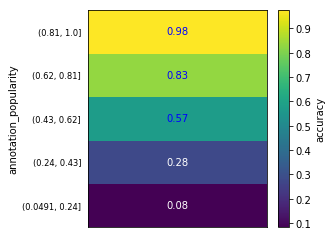

In [18]:
# Fairness through the angle of the annotations and their accuracy. 
metric_result, data_metric = metrics_inclusiveness_test.compute_metric(prediction_col, 'label', 'annotation_popularity', ('accuracy',), characterization=True)
print(metric_result, data_metric)

TODO: check whether bins are in order


..\aif360\metrics\inclusiveness_label_dataset_metric.py:79: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = data.as_matrix(columns=[metric])
c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
..\aif360\metrics\inclusiveness_label_dataset_metric.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  matrix_data = data.as_matrix([metric])


{'accuracy': (0.6673991811562909, 0.5487413534324568), 'F1': (0.7326340519364738, 0.2853168622658066), 'TPR': (0.753675445429629, 0.22289683661784016), 'TNR': (0.854419109204218, 0.8659842925546896), 'FPR': (0.854419109204218, 0.13401570744531038), 'FNR': (0.753675445429629, 0.7771031633821599)}                 level_0   index       rev_id  worker_id  label  label_score  \
bin_col                                                                       
(0.0491, 0.24]   186944  226935   69111073.0       2942      1         -1.0   
(0.24, 0.43]      72170   87641   33975178.0        302      1         -1.0   
(0.43, 0.62]     185426  225120   68781472.0       2797      1         -1.0   
(0.62, 0.81]     162002  196742   62185549.0        461      0          0.0   
(0.81, 1.0]      289255  351140  108933028.0       2855      0          1.0   

               gender  english_first_language age_group  education    ...     \
bin_col                                                              

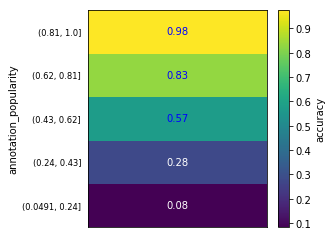

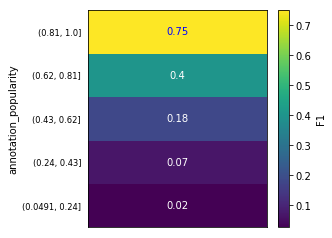

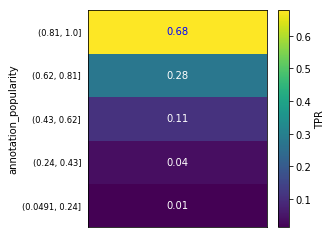

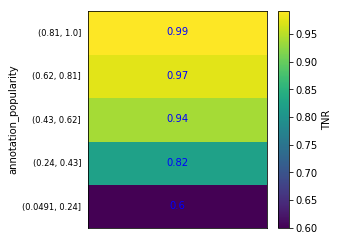

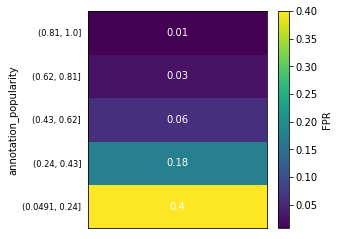

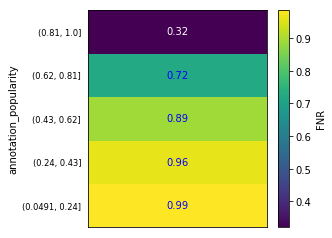

In [19]:
# Fairness through the angle of the annotations and their accuracy, F-measure and other rates. 
metric_result, data_metric = metrics_inclusiveness_test.compute_metric(prediction_col, 'label', 'annotation_popularity', ('accuracy', 'F1', 'TPR', 'TNR', 'FPR', 'FNR'), characterization=True)
print(metric_result, data_metric)

TODO: check whether bins are in order
{'accuracy': (0.9643748686851529, 0.8832243701469604), 'F1': (0.9021203495067396, 0.41771009877148085), 'TPR': (0.9093877461405704, 0.2943482672072319), 'TNR': (0.9823905785207635, 0.9835474680431354), 'FPR': (0.9823905785207635, 0.016452531956864462), 'FNR': (0.9093877461405704, 0.7056517327927679)}                              level_0   index       rev_id  worker_id  label  \
pop_label                                                                     
male 30-45 bachelors          289255  351140  108933028.0       2855      0   
male 18-30 professional       105040  127747   44547670.0        885      1   
male 18-30 some               375760  456180  147318846.0        997      0   
male 18-30 hs                  10656   12939    8671965.0       2867      0   
male 18-30 bachelors          171953  208741   65218095.0       2356      0   
female 18-30 professional     158410  192378   60927662.0       3589      0   
female 45-60 bachelors      

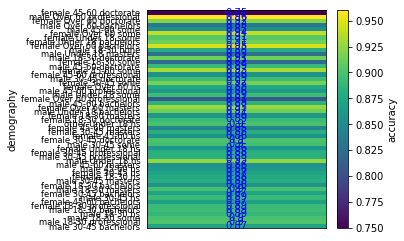

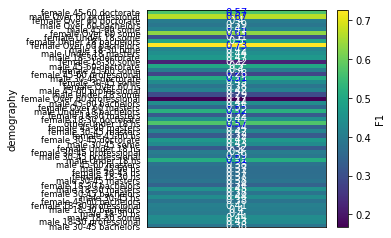

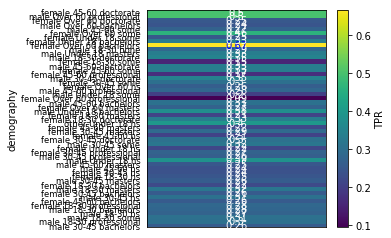

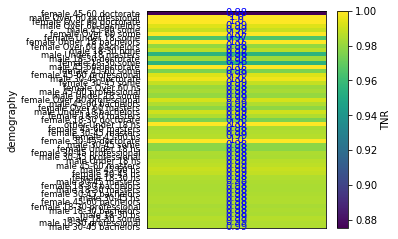

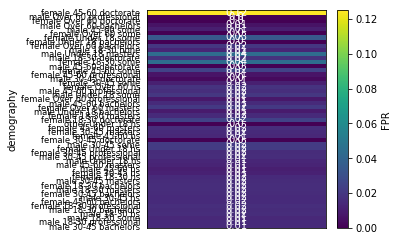

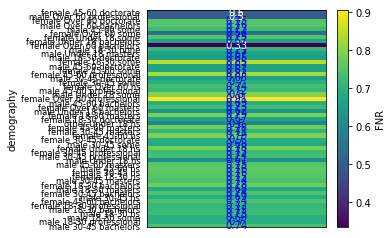

In [20]:
# Fairness through the angle of the user demographics and several performance measures. 
metric_result, data_metric = metrics_inclusiveness_test.compute_metric(prediction_col, 'label', 'demography', ('accuracy', 'F1', 'TPR', 'TNR', 'FPR', 'FNR'), characterization=True)
print(metric_result, data_metric)

In [23]:
# Fairness through the angle of the samples and several performance measures.  
metric_result, data_metric = metrics_inclusiveness_test.compute_metric(prediction_col, 'label', 'sample_ambiguity', ('accuracy', 'F1', 'TPR', 'TNR', 'FPR', 'FNR'))
print(metric_result, data_metric)

c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


TODO: check whether bins are in order
{'accuracy': (0.8272172268593815, 0.7343765754766309), 'F1': (0.9926695109608773, 0.04737175004726971), 'TPR': (nan, nan), 'TNR': (nan, nan), 'FPR': (nan, nan), 'FNR': (nan, nan)}                   level_0          index        rev_id    worker_id     label  \
bin_col                                                                         
(0.5, 0.6]  206368.492642  250565.685953  8.043747e+07  1979.623077  0.493311   
(0.6, 0.7]  203263.252974  246792.773268  7.934282e+07  2048.820854  0.428971   
(0.7, 0.8]  205267.131524  249223.457992  7.993812e+07  2004.291130  0.299087   
(0.8, 0.9]  204461.428949  248246.075736  7.973806e+07  2029.867821  0.173630   
(0.9, 1.0]  206759.609707  251036.219702  8.074720e+07  1919.092893  0.043314   

            label_score  english_first_language  sample_agreement        MV  \
bin_col                                                                       
(0.5, 0.6]    -0.364883                0.180602         

..\aif360\metrics\inclusiveness_label_dataset_metric.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  matrix_data = data.as_matrix([metric])
c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\numpy\lib\nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
..\aif360\metrics\inclusiveness_label_dataset_metric.py:32: RuntimeWarning: Mean of empty slice
  return 1 - np.nanstd(matrix_data), np.nanmean(matrix_data)


c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


TODO: check whether bins are in order


..\aif360\metrics\inclusiveness_label_dataset_metric.py:79: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = data.as_matrix(columns=[metric])
c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
..\aif360\metrics\inclusiveness_label_dataset_metric.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  matrix_data = data.as_matrix([metric])
c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\numpy\lib\nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
..\aif360\metrics\inclusiveness_label_dataset_metric.py:32: RuntimeWarning: Mea

{'accuracy': (0.8030310317312501, 0.6288096434565136), 'F1': (0.9004456494796964, 0.19816596910220227), 'TPR': (nan, nan), 'TNR': (nan, nan), 'FPR': (nan, nan), 'FNR': (nan, nan)}                           level_0          index        rev_id    worker_id  \
bin_col                                                                       
(-0.000646, 0.129]  207127.597484  251484.723270  8.083898e+07  2032.273750   
(0.129, 0.258]      197423.251989  239702.782493  7.700579e+07  2303.132626   
(0.258, 0.388]      206230.075472  250407.396226  8.114128e+07  2698.000000   
(0.388, 0.517]      212306.733333  257759.000000  8.278342e+07  2185.266667   
(0.517, 0.646]      209731.111111  254633.555556  7.972766e+07  3453.666667   

                       label  label_score  english_first_language  \
bin_col                                                             
(-0.000646, 0.129]  0.137703     0.245283                0.180073   
(0.129, 0.258]      0.228117     0.090186                0.

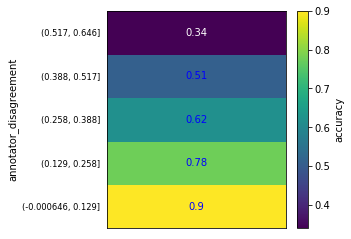

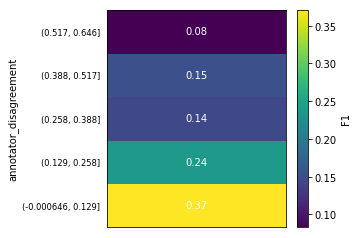

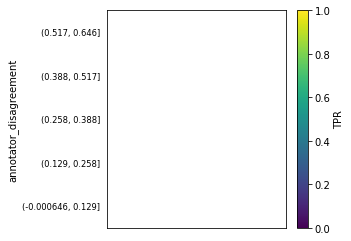

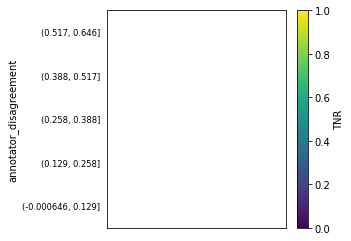

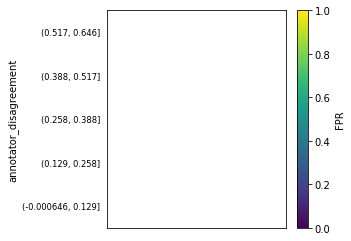

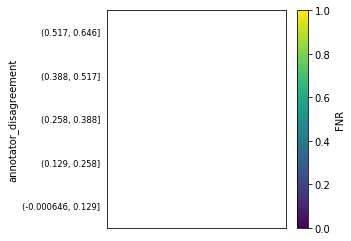

In [22]:
# Fairness through the angle of the users and several performance measures. 
metric_result, data_metric = metrics_inclusiveness_test.compute_metric(prediction_col, 'label', 'annotator_disagreement', ('accuracy', 'F1', 'TPR', 'TNR', 'FPR', 'FNR'), characterization=True)
print(metric_result, data_metric)